# 03 – Random Effects Logit/Probit

**Panel Data Econometrics with PanelBox**

This notebook covers **Random Effects (RE) Probit** models for binary panel data.
We compare four estimation strategies:

| Model | Handles heterogeneity | Uses all obs | Consistent if RE⊥X |
|---|---|---|---|
| Pooled Probit | No | Yes | Only if ρ = 0 |
| RE Probit | Yes (random) | Yes | Yes |
| FE Logit | Yes (fixed) | No (only switchers) | Yes |
| CRE Probit | Yes (correlated) | Yes | Yes |

**Dataset**: Female labor force participation (unbalanced panel).  
**Note**: For speed, main estimations use a random subsample of N=100 individuals.

**Prerequisites**: Notebooks 01 (Pooled) and 02 (Fixed Effects)

In [1]:
# ── Imports ──────────────────────────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from panelbox.models.discrete.binary import (
    PooledLogit, PooledProbit,
    FixedEffectsLogit, RandomEffectsProbit
)

SEED = 42
rng  = np.random.default_rng(SEED)

plt.rcParams.update({
    'figure.dpi': 100,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11,
})
sns.set_palette('muted')

# ── Load data ────────────────────────────────────────────────────────────────
DATA_PATH = '../data/labor_participation.csv'
data_full = pd.read_csv(DATA_PATH)

# ── Working sample: N=100 random individuals (for feasible computation) ──────
# RE Probit Hessian computation is O(k²·N·T·Q) per iteration
# With full N=1000, a single RE fit takes ~80s; N=100 takes ~3s
all_ids   = data_full['id'].unique()
sample_ids = rng.choice(all_ids, size=100, replace=False)
data      = data_full[data_full['id'].isin(sample_ids)].copy()

# Also keep full data available for Section 1 summary stats
print(f'Full dataset  : {data_full.shape[0]} obs, {len(all_ids)} individuals')
print(f'Working sample: {data.shape[0]} obs, {data["id"].nunique()} individuals')
print(f'Columns: {list(data.columns)}')
print(f'LFP rate: {data["lfp"].mean():.3f}')
data.head()

Full dataset  : 5000 obs, 1000 individuals
Working sample: 500 obs, 100 individuals
Columns: ['id', 'year', 'lfp', 'age', 'educ', 'kids', 'married', 'exper']
LFP rate: 0.572


,id,year,lfp,age,educ,kids,married,exper
205,42,1,0,33,13,0,0,16
206,42,2,1,34,13,0,0,17
207,42,3,0,35,13,0,0,18
208,42,4,0,36,13,0,0,19
209,42,5,1,37,13,0,0,20


---
## 1. Why Random Effects? Motivation

### The sample-loss problem with Fixed Effects

Fixed Effects Logit conditions on sufficient statistics to eliminate $\alpha_i$.
Only individuals who **switch** (change $y_{it}$ over time) contribute.
**Random Effects keeps all observations** by integrating $\alpha_i$ out of the likelihood.

### Time-invariant variables

Variables with no within-individual variation are collinear with FE and dropped.
RE allows their identification.

In [2]:
# ── Sample utilization: FE vs RE (full dataset for illustration) ──────────
n_total   = data_full['id'].nunique()
variation = data_full.groupby('id')['lfp'].std()
switchers = (variation > 0).sum()
non_sw    = (variation == 0).sum()

print('=== Sample Utilization (full dataset, N=1000) ===')
print(f'Total individuals : {n_total}')
print(f'Switchers         : {switchers}  ({100*switchers/n_total:.1f}%)')
print(f'Non-switchers     : {non_sw}   ({100*non_sw/n_total:.1f}%)  <-- lost in FE Logit')
print(f'RE Probit uses    : {n_total}  (100.0%)')

# Quick FE Logit on the working sample
print(f'\nFitting FE Logit on working sample (N={data["id"].nunique()})...')
fe_m = FixedEffectsLogit('lfp ~ age + educ + kids + married + exper', data, 'id', 'year')
fe_r = fe_m.fit()
print(f'FE Logit done. Used entities: {getattr(fe_m, "n_used_entities", "N/A")}')

=== Sample Utilization (full dataset, N=1000) ===
Total individuals : 1000
Switchers         : 794  (79.4%)
Non-switchers     : 206   (20.6%)  <-- lost in FE Logit
RE Probit uses    : 1000  (100.0%)

Fitting FE Logit on working sample (N=100)...


FE Logit done. Used entities: 76


In [3]:
# Within vs Between variation decomposition
covs = ['age', 'educ', 'kids', 'married', 'exper']
within_std  = data_full.groupby('id')[covs].std().mean()
between_std = data_full.groupby('id')[covs].mean().std()

var_df = pd.DataFrame({'Within SD': within_std, 'Between SD': between_std})
var_df['W/B ratio'] = (var_df['Within SD'] / var_df['Between SD']).round(4)
print('Variation decomposition (low W/B ratio = harder to identify with FE):')
print(var_df.round(4))

Variation decomposition (low W/B ratio = harder to identify with FE):
         Within SD  Between SD  W/B ratio
age         1.5811      5.6909     0.2778
educ        0.0000      2.3201     0.0000
kids        0.8040      0.3465     2.3200
married     0.4864      0.2152     2.2604
exper       1.5811      6.2194     0.2542


---
## 2. Random Effects Model Specification

### The RE Probit model

$$y^*_{it} = \mathbf{x}_{it}'\boldsymbol{\beta} + \alpha_i + \varepsilon_{it}, \quad y_{it} = \mathbf{1}[y^*_{it} > 0]$$

**Random effects assumption**: $\alpha_i \mid \mathbf{X}_i \sim N(0, \sigma^2_\alpha)$

### Marginal likelihood

$$L_i = \int_{-\infty}^{+\infty}\prod_{t=1}^{T_i} \Phi\left((2y_{it}-1)(x_{it}'\beta + \alpha_i)\right) \phi\left(\frac{\alpha_i}{\sigma_\alpha}\right) \frac{d\alpha_i}{\sigma_\alpha}$$

### Intraclass Correlation Coefficient (ICC)

$$\rho = \frac{\sigma^2_\alpha}{\sigma^2_\alpha + 1}$$

- $\rho = 0$: No heterogeneity → Pooled Probit consistent
- $\rho > 0$: Significant heterogeneity → RE Probit preferred

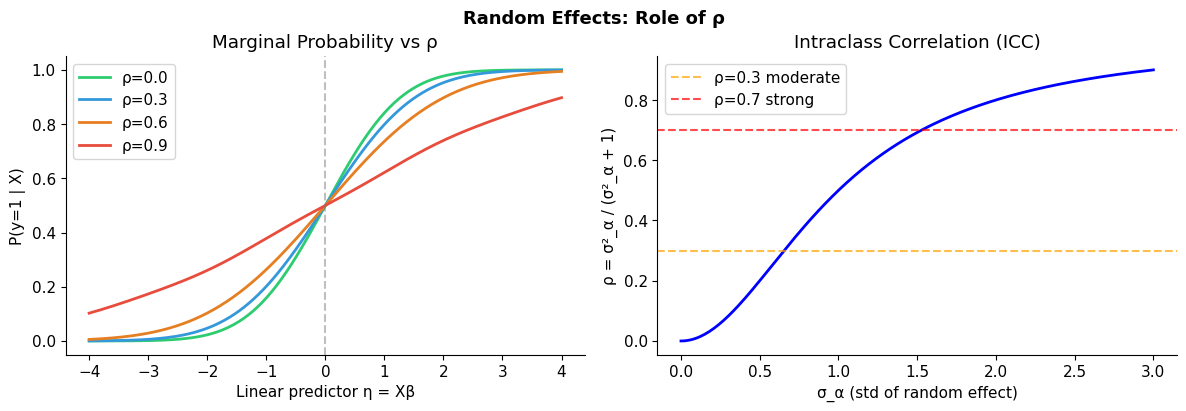

Figure saved.


In [4]:
# ── Visualize role of ρ (pure math, no model fitting) ─────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x_grid   = np.linspace(-4, 4, 300)
rho_vals = [0.0, 0.3, 0.6, 0.9]
colors   = ['#2ecc71', '#3498db', '#e67e22', '#e74c3c']

gh_nd, gh_wt = np.polynomial.hermite.hermgauss(16)
gh_nd_std    = gh_nd * np.sqrt(2)
gh_wt_norm   = gh_wt / np.sqrt(np.pi)

ax = axes[0]
for rho, c in zip(rho_vals, colors):
    sigma_a = np.sqrt(rho / max(1 - rho, 1e-8))
    probs   = [np.sum(gh_wt_norm * stats.norm.cdf(eta + sigma_a * gh_nd_std)) for eta in x_grid]
    ax.plot(x_grid, probs, color=c, linewidth=2, label=f'ρ={rho}')
ax.set_xlabel('Linear predictor η = Xβ')
ax.set_ylabel('P(y=1 | X)')
ax.set_title('Marginal Probability vs ρ')
ax.legend()
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

ax = axes[1]
sigma_range = np.linspace(0, 3, 200)
rho_range   = sigma_range**2 / (sigma_range**2 + 1)
ax.plot(sigma_range, rho_range, 'b-', linewidth=2)
ax.set_xlabel('σ_α (std of random effect)')
ax.set_ylabel('ρ = σ²_α / (σ²_α + 1)')
ax.set_title('Intraclass Correlation (ICC)')
ax.axhline(y=0.3, color='orange', linestyle='--', alpha=0.7, label='ρ=0.3 moderate')
ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='ρ=0.7 strong')
ax.legend()

plt.tight_layout()
plt.suptitle('Random Effects: Role of ρ', fontsize=13, fontweight='bold', y=1.02)
plt.savefig('../outputs/s2_rho_illustration.png', dpi=80, bbox_inches='tight')
plt.show()
print('Figure saved.')

---
## 3. Gauss-Hermite Quadrature

The intractable integral is approximated:

$$L_i \approx \frac{1}{\sqrt{\pi}} \sum_{q=1}^{Q} w_q \prod_{t=1}^{T_i} \Phi\left((2y_{it}-1)(x_{it}'\beta + \sqrt{2}\sigma_\alpha x_q)\right)$$

where $(x_q, w_q)$ are the $Q$ Gauss-Hermite nodes and weights.

**PanelBox default**: $Q = 12$ (sufficient for most applications).

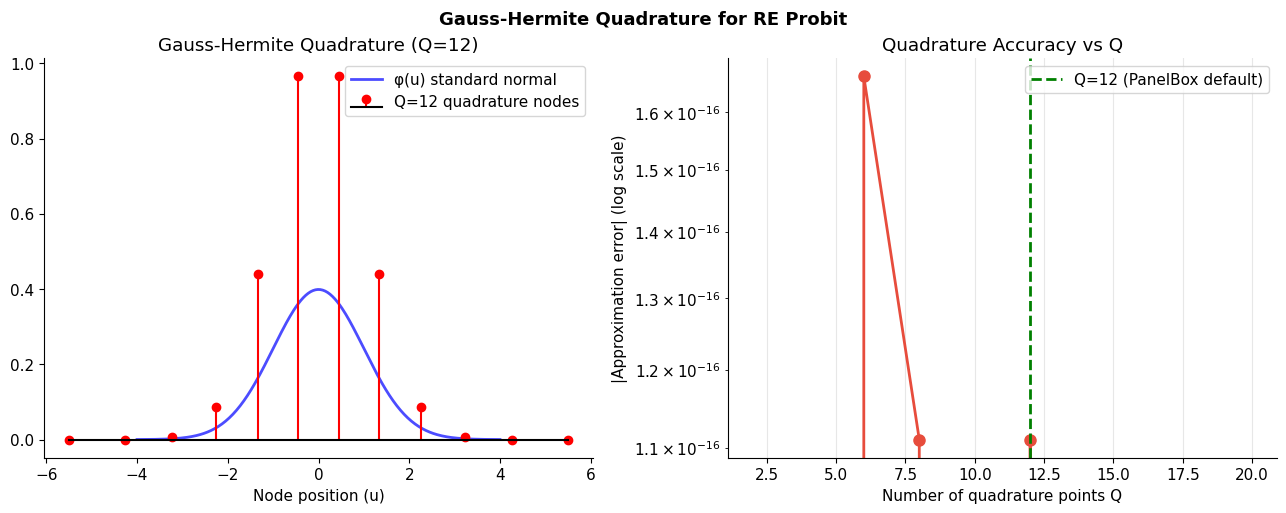

Accuracy at Q=12 : 1.11e-16
Accuracy at Q=20 : 0.00e+00


In [5]:
# ── Visualize Gauss-Hermite nodes and accuracy (pure math, no model fitting) ──
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
Q = 12
nodes, weights = np.polynomial.hermite.hermgauss(Q)
normal_nodes   = nodes * np.sqrt(2)
normal_weights = weights / np.sqrt(np.pi)

x_range = np.linspace(-4, 4, 300)
ax.plot(x_range, stats.norm.pdf(x_range), 'b-', lw=2, label='φ(u) standard normal', alpha=0.7)
ax.stem(normal_nodes, normal_weights * 3,
        linefmt='r-', markerfmt='ro', basefmt='k-',
        label=f'Q={Q} quadrature nodes')
ax.set_xlabel('Node position (u)')
ax.set_title(f'Gauss-Hermite Quadrature (Q={Q})')
ax.legend()

ax = axes[1]
Q_values = [2, 4, 6, 8, 10, 12, 16, 20]
errors   = []
# Test: ∫ Φ(u) φ(u) du = 0.5 (exact)
for q in Q_values:
    nd, wt  = np.polynomial.hermite.hermgauss(q)
    wt_norm = wt / np.sqrt(np.pi)
    nd_std  = nd * np.sqrt(2)
    approx  = np.sum(wt_norm * stats.norm.cdf(nd_std))
    errors.append(abs(approx - 0.5))

ax.semilogy(Q_values, errors, 'o-', lw=2, markersize=8, color='#e74c3c')
ax.axvline(x=12, color='green', linestyle='--', lw=2, label='Q=12 (PanelBox default)')
ax.set_xlabel('Number of quadrature points Q')
ax.set_ylabel('|Approximation error| (log scale)')
ax.set_title('Quadrature Accuracy vs Q')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Gauss-Hermite Quadrature for RE Probit', fontsize=13, fontweight='bold', y=1.02)
plt.savefig('../outputs/s3_quadrature.png', dpi=80, bbox_inches='tight')
plt.show()

print(f'Accuracy at Q=12 : {errors[Q_values.index(12)]:.2e}')
print(f'Accuracy at Q=20 : {errors[Q_values.index(20)]:.2e}')

### Quadrature convergence: effect on coefficient estimates

We test whether different values of $Q$ produce the same coefficient estimates.
Using working sample (N=100, Q=8 vs Q=12 vs Q=16).

In [6]:
# ── Quadrature convergence test (N=100 working sample, 1 variable for speed) ──
# With k=1 predictor, Hessian needs (k+1)*((k+1)+1) = 2*3 = 6 evaluations only
id_counts  = data.groupby('id').size()
conv_formula = 'lfp ~ age'
Q_test       = [8, 12, 16]

conv_results = {}
for q in Q_test:
    print(f'  Q={q}...', end=' ', flush=True)
    m = RandomEffectsProbit(conv_formula, data, 'id', 'year', quadrature_points=q)
    r = m.fit()
    conv_results[q] = r.params
    print(f'age_coef={r.params["age"]:.6f}')

disp_vars = ['Intercept', 'age']
conv_df = pd.DataFrame(
    {q: [conv_results[q][v] for v in disp_vars] for q in Q_test},
    index=disp_vars
).T
conv_df.index.name = 'Q'
print('\nCoefficients by Q:')
print(conv_df.round(6))

diff = max(abs(conv_results[16]['age'] - conv_results[12]['age']),
           abs(conv_results[16]['Intercept'] - conv_results[12]['Intercept']))
print(f'\nMax |Δcoef| Q=12 vs Q=16: {diff:.8f}')
print(f'Q=12 sufficient (3-decimal): {"YES" if diff < 0.001 else "NO"}')

  Q=8... 

age_coef=0.016016
  Q=12... 

age_coef=0.015971
  Q=16... 

age_coef=0.015972

Coefficients by Q:
    Intercept       age
Q                      
8   -0.373638  0.016016
12  -0.370729  0.015971
16  -0.370666  0.015972

Max |Δcoef| Q=12 vs Q=16: 0.00006295
Q=12 sufficient (3-decimal): YES


---
## 4. Estimating RE Probit – Full Model

`RandomEffectsProbit(formula, data, entity_col, time_col, quadrature_points=12)`

Returns a `PanelResults` object with:
- Standard: `params`, `std_errors`, `pvalues`, `llf`, `aic`, `bic`
- RE-specific: `sigma_alpha`, `rho`, `quadrature_points`

In [7]:
# ── Fit RE Probit on working sample (N=100) ────────────────────────────────
# Q=8 for speed (vs default Q=12 which is slightly more accurate)
base_formula = 'lfp ~ age + educ + kids + married'

print(f'Fitting RE Probit (N={data["id"].nunique()}, Q=8)...')
re_full = RandomEffectsProbit(base_formula, data, 'id', 'year', quadrature_points=8)
re_res  = re_full.fit()

print('\n=== RE Probit Results ===')
print(re_res.summary())

Fitting RE Probit (N=100, Q=8)...



=== RE Probit Results ===
                   Random Effects Probit Estimation Results                   
Formula: lfp ~ age + educ + kids + married
Model:   Random Effects Probit
------------------------------------------------------------------------------
No. Observations:                 500
No. Entities:                     100
No. Time Periods:                   5
Degrees of Freedom:               494
R-squared:                     0.0820
R-squared (overall):           0.0820
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept           -1.5632      0.7158  -2.184  0.0294   -2.9696   -0.1569 *
age                  0.0140      0.0167   0.836  0.4036   -0.0189    0.0469 
educ                 0.1038      0.0407   2.547  0.0112    0.0237    0.1838 *
kids                -0.2304      0.0760  -3.033  0.0025   -0.3796   -0.0811 **
ma

In [8]:
# ── RE-specific parameters and LR test ────────────────────────────────────
sigma_a = re_res.sigma_alpha
rho     = re_res.rho

print(f'σ_α (std of random effect)    = {sigma_a:.4f}')
print(f'ρ   (intraclass correlation)  = {rho:.4f}')
print(f'\n{100*rho:.1f}% of latent variance is due to individual heterogeneity.')

if rho > 0.3:
    print('→ Substantial heterogeneity: RE clearly preferred over Pooled Probit.')
elif rho > 0.1:
    print('→ Moderate heterogeneity: RE preferred over Pooled Probit.')
else:
    print('→ Weak heterogeneity: Pooled Probit may be adequate.')

# LR test H0: ρ=0
print('\nFitting Pooled Probit for LR test...')
pool_m   = PooledProbit(base_formula, data, 'id', 'year')
pool_res = pool_m.fit()

lr_stat = 2 * (re_res.llf - pool_res.llf)
lr_pval = 0.5 * stats.chi2.sf(lr_stat, df=1)  # one-sided: ρ≥0

print(f'\nLR test H₀: ρ=0')
print(f'  LR stat  : {lr_stat:.4f}')
print(f'  p-value  : {lr_pval:.6f}  (one-sided, correct for ρ≥0)')
print(f'  Decision : {"Reject H₀" if lr_pval < 0.05 else "Fail to reject"}')

σ_α (std of random effect)    = 0.6907
ρ   (intraclass correlation)  = 0.3230

32.3% of latent variance is due to individual heterogeneity.
→ Substantial heterogeneity: RE clearly preferred over Pooled Probit.

Fitting Pooled Probit for LR test...

LR test H₀: ρ=0
  LR stat  : 30.3775
  p-value  : 0.000000  (one-sided, correct for ρ≥0)
  Decision : Reject H₀


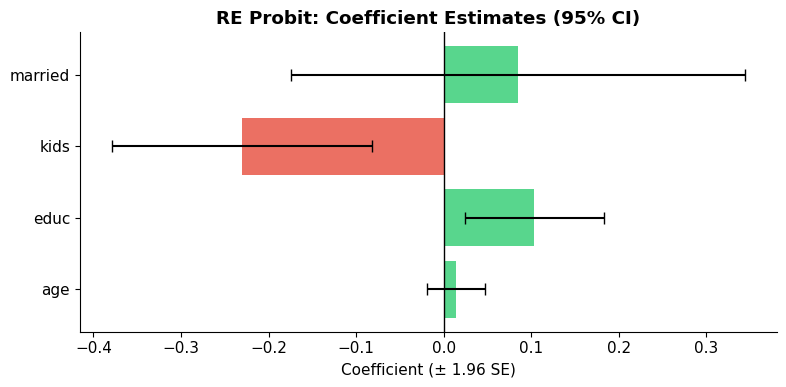

In [9]:
# ── Coefficient plot ───────────────────────────────────────────────────────
coef_names = [c for c in re_res.params.index if c not in ['Intercept', 'log_sigma_alpha']]
coefs  = re_res.params[coef_names].values
ses    = re_res.std_errors[coef_names].values

fig, ax = plt.subplots(figsize=(8, 4))
y_pos   = np.arange(len(coef_names))
ax.barh(y_pos, coefs, xerr=1.96*ses,
        color=['#e74c3c' if c < 0 else '#2ecc71' for c in coefs],
        alpha=0.8, capsize=4)
ax.axvline(x=0, color='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(coef_names)
ax.set_xlabel('Coefficient (± 1.96 SE)')
ax.set_title('RE Probit: Coefficient Estimates (95% CI)', fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/s4_coef_plot.png', dpi=80, bbox_inches='tight')
plt.show()

---
## 5. Correlated Random Effects (CRE) – Mundlak-Chamberlain Device

**Problem**: RE Probit assumes $\alpha_i \perp \mathbf{X}_i$. If violated, RE is biased.

**Solution (Mundlak 1978, Chamberlain 1980)**:

$$\alpha_i = \bar{\mathbf{x}}_i'\boldsymbol{\lambda} + u_i, \quad u_i \sim N(0, \sigma^2_u)$$

Resulting model:
$$y^*_{it} = \mathbf{x}_{it}'\boldsymbol{\beta} + \bar{\mathbf{x}}_i'\boldsymbol{\lambda} + u_i + \varepsilon_{it}$$

**Mundlak test**: H₀: $\boldsymbol{\lambda} = \mathbf{0}$ (RE exogeneity holds).

In [10]:
# ── Construct Mundlak terms ────────────────────────────────────────────────
time_varying_vars = ['age', 'kids', 'married']
means = data.groupby('id')[time_varying_vars].mean()
means.columns = [v + '_mean' for v in time_varying_vars]
data_cre = data.merge(means, on='id')

cre_formula = 'lfp ~ age + educ + kids + married + age_mean + kids_mean + married_mean'
print(f'CRE formula: {cre_formula}')
print(f'Mundlak terms: {list(means.columns)}')
data_cre[['id', 'year', 'age', 'age_mean']].head(6)

CRE formula: lfp ~ age + educ + kids + married + age_mean + kids_mean + married_mean
Mundlak terms: ['age_mean', 'kids_mean', 'married_mean']


,id,year,age,age_mean
0,42,1,33,35.0
1,42,2,34,35.0
2,42,3,35,35.0
3,42,4,36,35.0
4,42,5,37,35.0
5,60,1,38,40.0


In [11]:
# ── Fit CRE model ──────────────────────────────────────────────────────────
print(f'Fitting CRE Probit (N={data["id"].nunique()}, Q=8)...')
cre_model = RandomEffectsProbit(cre_formula, data_cre, 'id', 'year', quadrature_points=8)
cre_res   = cre_model.fit()

print('\n=== CRE Probit Results ===')
print(cre_res.summary())

Fitting CRE Probit (N=100, Q=8)...



=== CRE Probit Results ===
                   Random Effects Probit Estimation Results                   
Formula: lfp ~ age + educ + kids + married + age_mean + kids_mean + married_mean
Model:   Random Effects Probit
------------------------------------------------------------------------------
No. Observations:                 500
No. Entities:                     100
No. Time Periods:                   5
Degrees of Freedom:               491
R-squared:                     0.0897
R-squared (overall):           0.0897
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept           -1.4588      0.7484  -1.949  0.0518   -2.9292    0.0117 .
age                  0.0581      0.0499   1.164  0.2450   -0.0400    0.1562 
educ                 0.1087      0.0404   2.688  0.0074    0.0293    0.1882 **
kids                -0.2310      0.0876  

In [12]:
# ── Mundlak exogeneity Wald test ───────────────────────────────────────────
mundlak_vars = ['age_mean', 'kids_mean', 'married_mean']

lambda_hat = cre_res.params[mundlak_vars].values
V_cov      = cre_res.cov_params.loc[mundlak_vars, mundlak_vars].values

try:
    V_inv  = np.linalg.inv(V_cov)
    W_stat = lambda_hat @ V_inv @ lambda_hat
    df_t   = len(mundlak_vars)
    W_pval = stats.chi2.sf(W_stat, df=df_t)
    print('=== Mundlak Exogeneity Test ===')
    print(f'H₀: λ = 0 for {mundlak_vars}')
    print(f'Wald stat : {W_stat:.4f}')
    print(f'df        : {df_t}')
    print(f'p-value   : {W_pval:.4f}')
    print(f'Decision  : {"Reject H₀" if W_pval<0.05 else "Fail to reject"}')
    print('\nMundlak term estimates:')
    for v in mundlak_vars:
        se = cre_res.std_errors[v]
        t  = cre_res.params[v] / se
        print(f'  {v:15s}: λ = {cre_res.params[v]:7.4f}  SE = {se:.4f}  t = {t:.2f}')
except np.linalg.LinAlgError:
    print('Warning: singular covariance matrix; cannot compute Wald test.')
    W_stat, W_pval = np.nan, np.nan

=== Mundlak Exogeneity Test ===
H₀: λ = 0 for ['age_mean', 'kids_mean', 'married_mean']
Wald stat : 5.3091
df        : 3
p-value   : 0.1505
Decision  : Fail to reject

Mundlak term estimates:
  age_mean       : λ = -0.0483  SE = 0.0529  t = -0.91
  kids_mean      : λ = -0.4263  SE = 0.2732  t = -1.56
  married_mean   : λ =  0.5558  SE = 0.4227  t = 1.31


---
## 6. Comparing All Four Models

We compare Pooled Probit, RE Probit, FE Logit, and CRE Probit.
All models are already estimated above — we simply collect and compare results.

In [13]:
# ── Collect results from all models ────────────────────────────────────────
model_names = ['Pooled Probit', 'RE Probit', 'FE Logit', 'CRE Probit']
model_res   = [pool_res, re_res, fe_r, cre_res]
common_vars = ['age', 'kids', 'married']

rows = []
for name, res in zip(model_names, model_res):
    row = {'Model': name}
    for v in common_vars:
        if v in res.params.index:
            row[v]         = res.params[v]
            row[v + '_se'] = res.std_errors[v]
        else:
            row[v] = row[v + '_se'] = np.nan
    try:
        row['logL'] = res.llf if res.llf is not None else np.nan
    except Exception:
        row['logL'] = np.nan
    rows.append(row)

comp_df = pd.DataFrame(rows).set_index('Model')
print('=== Coefficient Comparison ===')
print(comp_df[common_vars + ['logL']].round(4))

=== Coefficient Comparison ===
                  age    kids  married      logL
Model                                           
Pooled Probit  0.0089 -0.2165   0.1135 -328.5807
RE Probit      0.0140 -0.2304   0.0854 -313.3920
FE Logit       0.0462 -0.3799   0.0497 -143.8157
CRE Probit     0.0581 -0.2310   0.0228 -310.7536


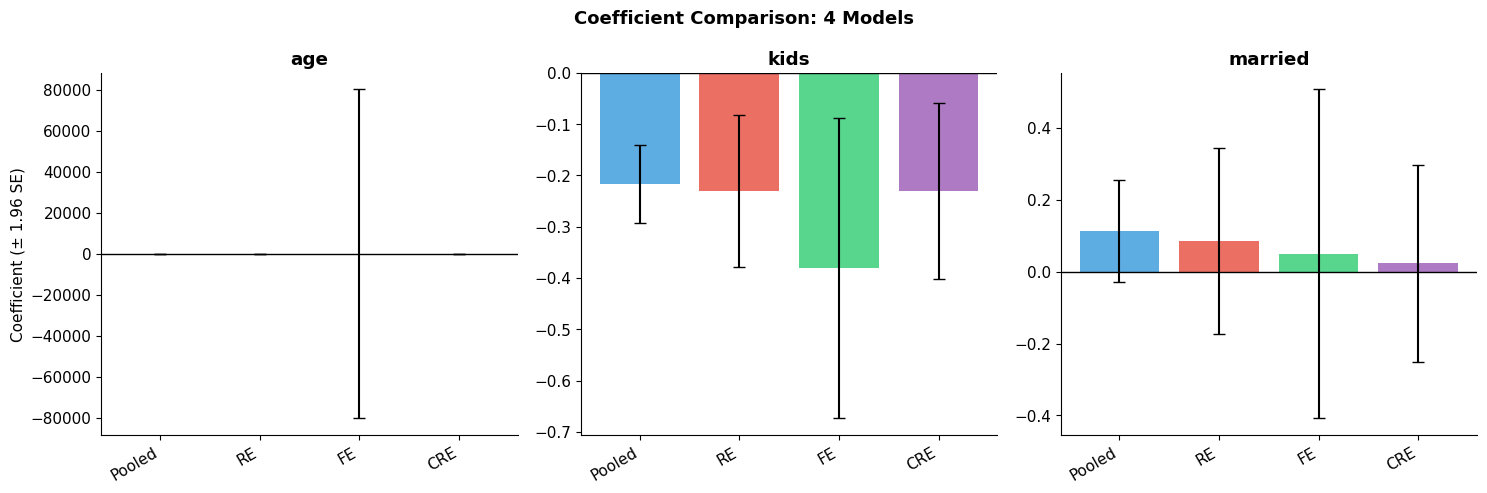


=== Summary Table ===
Model                   age       kids    married      log-L
--------------------------------------------------------
Pooled Probit        0.0089    -0.2165     0.1135    -328.58
RE Probit            0.0140    -0.2304     0.0854    -313.39
FE Logit             0.0462    -0.3799     0.0497    -143.82
CRE Probit           0.0581    -0.2310     0.0228    -310.75


In [14]:
# ── Coefficient comparison plot ────────────────────────────────────────────
n_vars    = len(common_vars)
fig, axes = plt.subplots(1, n_vars, figsize=(5*n_vars, 5))
colors_m  = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

for j, var in enumerate(common_vars):
    ax = axes[j]
    for i, (name, res) in enumerate(zip(model_names, model_res)):
        if var in res.params.index:
            coef = res.params[var]
            se   = res.std_errors[var]
            ax.bar(i, coef, color=colors_m[i], alpha=0.8)
            ax.errorbar(i, coef, yerr=1.96*se, fmt='none', color='black', capsize=4)
    ax.axhline(y=0, color='black', lw=1)
    ax.set_title(var, fontweight='bold')
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels([n.split()[0] for n in model_names], rotation=30, ha='right')
    if j == 0:
        ax.set_ylabel('Coefficient (± 1.96 SE)')

plt.suptitle('Coefficient Comparison: 4 Models', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/s6_comparison.png', dpi=80, bbox_inches='tight')
plt.show()

print('\n=== Summary Table ===')
print(f'{"Model":<16} {"age":>10} {"kids":>10} {"married":>10} {"log-L":>10}')
print('-'*56)
for name, res in zip(model_names, model_res):
    def get_c(r, v):
        return f'{r.params[v]:.4f}' if v in r.params.index else '  N/A  '
    ll_v = f'{res.llf:.2f}' if (hasattr(res, 'llf') and res.llf is not None) else 'N/A'
    print(f'{name:<16} {get_c(res,"age"):>10} {get_c(res,"kids"):>10} {get_c(res,"married"):>10} {ll_v:>10}')

---
## 7. Decision Framework: Which Model to Use?

| Question | Test | Outcome → Model |
|---|---|---|
| Is ρ significant? | LR test H₀:ρ=0 | No → Pooled; Yes → proceed |
| Is α_i correlated with X? | Mundlak Wald H₀:λ=0 | No → RE; Yes → proceed |
| Many switchers (>50%)? | Count | Yes → FE; No → CRE |

**Key insight**: CRE is consistent under endogeneity like FE,
but retains all observations like RE.

In [15]:
# ── Decision framework using pre-computed results ──────────────────────────
lr_stat_d = 2 * (re_res.llf - pool_res.llf)
lr_pval_d = 0.5 * stats.chi2.sf(lr_stat_d, df=1)

try:
    W_stat_d = lambda_hat @ np.linalg.inv(V_cov) @ lambda_hat
    W_pval_d = stats.chi2.sf(W_stat_d, df=len(mundlak_vars))
except Exception:
    W_stat_d, W_pval_d = np.nan, np.nan

variation_d = data.groupby('id')['lfp'].std()
pct_sw_d    = (variation_d > 0).sum() / data['id'].nunique()

print('=== Decision Framework ===')
print(f'Step 1 – LR test: stat={lr_stat_d:.3f}, p={lr_pval_d:.4f}, ρ={re_res.rho:.4f}')

if lr_pval_d >= 0.05:
    rec = 'Pooled Probit'
    print('  → Pooled Probit adequate')
else:
    print('  → Heterogeneity significant; proceed to Step 2')
    print(f'\nStep 2 – Mundlak: stat={W_stat_d:.3f}, p={W_pval_d:.4f}')
    if np.isnan(W_pval_d) or W_pval_d >= 0.05:
        rec = 'RE Probit'
        print('  → RE Probit: exogeneity not rejected')
    elif pct_sw_d >= 0.5:
        rec = 'FE Logit'
        print(f'  → FE Logit: {100*pct_sw_d:.1f}% switchers, endogenous effects')
    else:
        rec = 'CRE Probit'
        print(f'  → CRE Probit: endogenous effects, only {100*pct_sw_d:.1f}% switchers')

print(f'\n*** RECOMMENDED MODEL: {rec} ***')

=== Decision Framework ===
Step 1 – LR test: stat=30.378, p=0.0000, ρ=0.3230
  → Heterogeneity significant; proceed to Step 2

Step 2 – Mundlak: stat=5.309, p=0.1505
  → RE Probit: exogeneity not rejected

*** RECOMMENDED MODEL: RE Probit ***


---
## 8. Applied Analysis: Labor Force Participation

Complete interpretive analysis using RE Probit estimates,
including **Average Partial Effects (APE)**:

$$\text{APE}(x_j) = \frac{1}{N} \sum_i E_{\alpha}\left[\phi\left(\mathbf{x}'_{i}\boldsymbol{\beta} + \alpha_i\right)\right] \cdot \beta_j$$

In [16]:
# ── Average Partial Effects from RE Probit ─────────────────────────────────
X_cols      = ['age', 'educ', 'kids', 'married']
beta        = re_res.params[X_cols].values
beta_intcpt = re_res.params['Intercept']
sigma_a     = re_res.sigma_alpha
X_mat       = data[X_cols].values

gh_nd, gh_wt = np.polynomial.hermite.hermgauss(12)
gh_nd_std    = gh_nd * np.sqrt(2)
gh_wt_norm   = gh_wt / np.sqrt(np.pi)

lin_pred = beta_intcpt + X_mat @ beta
avg_phi  = np.zeros(len(X_mat))
for node, wt in zip(gh_nd_std, gh_wt_norm):
    avg_phi += wt * stats.norm.pdf(lin_pred + sigma_a * node)

scale_factor = avg_phi.mean()
ape_values   = scale_factor * beta

print('=== Average Partial Effects (RE Probit) ===')
print(f'{"Variable":<12} {"Coefficient":>12} {"APE":>12} {"Interpretation"}')
print('-'*60)
for var, coef, ape in zip(X_cols, beta, ape_values):
    print(f'{var:<12} {coef:>12.4f} {ape:>12.4f}    {ape*100:+.2f} pp per unit')
print(f'\nScale factor (avg φ): {scale_factor:.4f}')

=== Average Partial Effects (RE Probit) ===
Variable      Coefficient          APE Interpretation
------------------------------------------------------------
age                0.0140       0.0044    +0.44 pp per unit
educ               0.1038       0.0323    +3.23 pp per unit
kids              -0.2304      -0.0716    -7.16 pp per unit
married            0.0854       0.0265    +2.65 pp per unit

Scale factor (avg φ): 0.3108


In [17]:
# ── Predicted probabilities by demographic profile ─────────────────────────
profiles = {
    'Young, no kids, unmarried':  {'age': 25, 'educ': 12, 'kids': 0, 'married': 0},
    'Young, married, 1 kid':      {'age': 28, 'educ': 12, 'kids': 1, 'married': 1},
    'Middle, high educ, single':  {'age': 35, 'educ': 16, 'kids': 0, 'married': 0},
    'Middle, married, 2 kids':    {'age': 38, 'educ': 12, 'kids': 2, 'married': 1},
    'Older, no kids, single':     {'age': 50, 'educ': 14, 'kids': 0, 'married': 0},
}

print('=== Predicted P(LFP=1) by Profile ===')
print(f'{"Profile":<30} {"P(LFP=1)":>12}')
print('-'*44)
for name, prof in profiles.items():
    x_vec = np.array([prof[v] for v in X_cols])
    lin_p = beta_intcpt + x_vec @ beta
    prob  = sum(wt * stats.norm.cdf(lin_p + sigma_a * nd)
                for nd, wt in zip(gh_nd_std, gh_wt_norm))
    print(f'{name:<30} {prob:>12.4f}')

=== Predicted P(LFP=1) by Profile ===
Profile                            P(LFP=1)
--------------------------------------------
Young, no kids, unmarried            0.5105
Young, married, 1 kid                0.4767
Middle, high educ, single            0.6855
Middle, married, 2 kids              0.4472
Older, no kids, single               0.6862


---
## 9. Limitations and Extensions

### Limitations of RE Probit

1. **Distributional assumption**: $\alpha_i \sim N(0, \sigma^2_\alpha)$ is assumed.
   Misspecification leads to inconsistent estimates (unlike semi-parametric FE Logit).

2. **Exogeneity**: Requires $\alpha_i \perp \mathbf{X}_i$. Use CRE or FE if violated.

3. **Computational cost**: Hessian computation is $O(k^2 \cdot Q \cdot N \cdot T)$ per optimization
   step, making it slow for large datasets with many parameters.

### Extensions

| Extension | Description |
|---|---|
| **Dynamic RE Probit** | Add lagged $y_{it-1}$ (Heckman 1981 initial conditions) |
| **Bivariate RE Probit** | Two correlated binary outcomes |
| **Sample selection** | Heckman two-step with RE |
| **Finite mixture** | $\alpha_i$ from discrete mixture (avoids normality) |

In [18]:
# ── Sensitivity to normality: illustration with t(3) DGP ───────────────────
# Uses simulated data (N=100, T=4) — fast
rng2    = np.random.default_rng(2025)
N_sim, T_sim = 100, 4

alpha_true = rng2.standard_t(df=3, size=N_sim) * 0.5  # heavy-tailed, NOT normal
x_sim   = rng2.normal(size=(N_sim, T_sim))
latent  = x_sim * 1.0 + alpha_true[:, None] + rng2.normal(size=(N_sim, T_sim))
y_sim   = (latent > 0).astype(int)

ids_sim   = np.repeat(np.arange(N_sim), T_sim)
years_sim = np.tile(np.arange(T_sim), N_sim)
sim_df    = pd.DataFrame({'id': ids_sim, 'year': years_sim,
                          'y': y_sim.flatten(), 'x': x_sim.flatten()})

print('Fitting on t(3) DGP (misspecified as normal in RE)...')
pool_sim_r = PooledProbit('y ~ x', sim_df, 'id', 'year').fit()
re_sim_r   = RandomEffectsProbit('y ~ x', sim_df, 'id', 'year', quadrature_points=8).fit()

print(f'True β = 1.0')
print(f'Pooled Probit : β_x = {pool_sim_r.params["x"]:.4f}')
print(f'RE Probit     : β_x = {re_sim_r.params["x"]:.4f}  (assumes N, actually t(3))')
print(f'\nRE generally outperforms Pooled even with distributional misspecification.')

Fitting on t(3) DGP (misspecified as normal in RE)...


True β = 1.0
Pooled Probit : β_x = 0.7767
RE Probit     : β_x = 1.1420  (assumes N, actually t(3))

RE generally outperforms Pooled even with distributional misspecification.


---
## Exercises

### Exercise 1: Quadrature Convergence

**Easy** | Est. time: 5–10 min

1. Fit RE Probit for Q ∈ {8, 12, 16} using `lfp ~ age + educ + kids + married`
   on the working sample (N=100).
2. Plot each coefficient as a function of Q.
3. Compute `max |coef(Q=12) − coef(Q=16)|`.
4. Is Q=12 sufficient for 3-decimal precision?

  Q=8... 

done
  Q=12... 

done
  Q=16... 

done

Coefficients by Q:
         age      educ      kids   married
Q                                         
8   0.013996  0.103781 -0.230351  0.085383
12  0.013880  0.103748 -0.230185  0.085884
16  0.013874  0.103746 -0.230180  0.085901

Max |Δcoef| Q=12 vs Q=16: 0.00001696
Q=12 sufficient (3-decimal): YES


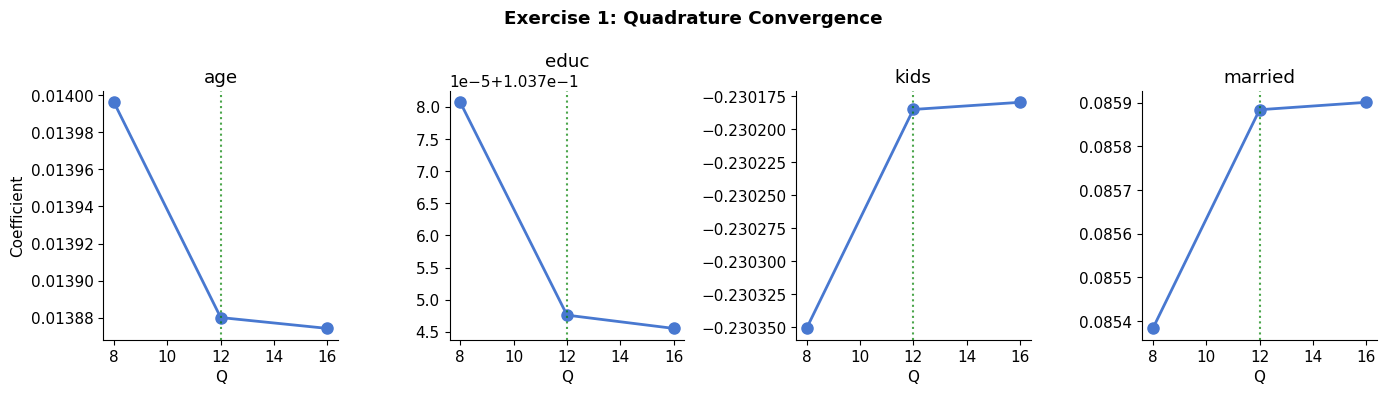

In [19]:
# Exercise 1: Quadrature convergence (N=100 working sample)
ex1_formula = 'lfp ~ age + educ + kids + married'
ex1_Q       = [8, 12, 16]
ex1_results = {}

for q in ex1_Q:
    print(f'  Q={q}...', end=' ', flush=True)
    r = RandomEffectsProbit(ex1_formula, data, 'id', 'year', quadrature_points=q).fit()
    ex1_results[q] = r.params
    print('done')

coef_vars = [v for v in ['age', 'educ', 'kids', 'married'] if v in ex1_results[ex1_Q[0]].index]
ex1_df = pd.DataFrame({q: [ex1_results[q][v] for v in coef_vars] for q in ex1_Q},
                       index=coef_vars).T
ex1_df.index.name = 'Q'
print('\nCoefficients by Q:')
print(ex1_df.round(6))

diffs    = {v: abs(ex1_results[16][v] - ex1_results[12][v]) for v in coef_vars}
max_diff = max(diffs.values())
print(f'\nMax |Δcoef| Q=12 vs Q=16: {max_diff:.8f}')
print(f'Q=12 sufficient (3-decimal): {"YES" if max_diff < 0.001 else "NO"}')

fig, axes = plt.subplots(1, len(coef_vars), figsize=(14, 4))
for j, var in enumerate(coef_vars):
    ax = axes[j]
    vals = [ex1_results[q][var] for q in ex1_Q]
    ax.plot(ex1_Q, vals, 'o-', lw=2, markersize=8)
    ax.axvline(x=12, color='green', linestyle=':', alpha=0.7, label='Q=12')
    ax.set_title(var)
    ax.set_xlabel('Q')
    if j == 0:
        ax.set_ylabel('Coefficient')
plt.suptitle('Exercise 1: Quadrature Convergence', fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/ex1_convergence.png', dpi=80, bbox_inches='tight')
plt.show()

### Exercise 2: CRE Specifications

**Medium** | Est. time: 5–10 min

Compare three CRE specifications:
1. CRE with only `age_mean` (partial Mundlak)
2. CRE with `age_mean + kids_mean + married_mean` (Section 5)
3. CRE with all time-varying means

In [20]:
# Exercise 2: CRE specifications
all_tv    = ['age', 'kids', 'married', 'exper']
means_all = data.groupby('id')[all_tv].mean()
means_all.columns = [v + '_mean' for v in all_tv]
data_ex2  = data.merge(means_all, on='id')

specs = [
    ('CRE-partial (age only)',
     'lfp ~ age + educ + kids + married + age_mean',
     ['age_mean']),
    ('CRE-main (3 vars)',
     'lfp ~ age + educ + kids + married + age_mean + kids_mean + married_mean',
     ['age_mean', 'kids_mean', 'married_mean']),
    ('CRE-full (all TV)',
     'lfp ~ age + educ + kids + married + age_mean + kids_mean + married_mean + exper_mean',
     ['age_mean', 'kids_mean', 'married_mean', 'exper_mean']),
]

print(f'{"Specification":<28} {"Wald":>8} {"p-val":>8} {"age_coef":>10}')
print('-'*60)
for spec_name, formula, mv in specs:
    m = RandomEffectsProbit(formula, data_ex2, 'id', 'year', quadrature_points=8)
    r = m.fit()
    lam = r.params[mv].values
    V   = r.cov_params.loc[mv, mv].values
    try:
        W  = lam @ np.linalg.inv(V) @ lam
        pv = stats.chi2.sf(W, df=len(mv))
    except Exception:
        W, pv = np.nan, np.nan
    age_c = r.params.get('age', np.nan)
    print(f'{spec_name:<28} {W:>8.3f} {pv:>8.4f} {age_c:>10.4f}')

Specification                    Wald    p-val   age_coef
------------------------------------------------------------


CRE-partial (age only)          1.343   0.2464     0.0679


CRE-main (3 vars)               5.309   0.1505     0.0581


CRE-full (all TV)               5.579   0.2329     0.0579


### Exercise 3: One-Sided vs Two-Sided LR Test

**Medium** | Est. time: 5–10 min

1. Compute LR stat for H₀: ρ=0.
2. Compare one-sided (correct) vs two-sided p-values.
3. What is the 5% critical value for each?

In [21]:
# Exercise 3: LR test comparison
lr_stat_ex3    = 2 * (re_res.llf - pool_res.llf)
pval_twosided  = stats.chi2.sf(lr_stat_ex3, df=1)
pval_onesided  = 0.5 * stats.chi2.sf(lr_stat_ex3, df=1)

print('=== LR Test for H₀: ρ=0 ===')
print(f'Pooled log-L : {pool_res.llf:.4f}')
print(f'RE log-L     : {re_res.llf:.4f}')
print(f'LR stat      : {lr_stat_ex3:.4f}')
print(f'\np-value (two-sided χ²₁) : {pval_twosided:.6f}  ← incorrect (ignores ρ≥0)')
print(f'p-value (one-sided)      : {pval_onesided:.6f}  ← correct')
print(f'Ratio one/two-sided      : {pval_onesided/pval_twosided:.2f}x')

cv_one = stats.chi2.ppf(0.90, df=1)
cv_two = stats.chi2.ppf(0.95, df=1)
print(f'\n5% critical values:')
print(f'  One-sided: {cv_one:.4f}')
print(f'  Two-sided: {cv_two:.4f}')
print(f'  LR stat {lr_stat_ex3:.4f} > one-sided cv? {lr_stat_ex3 > cv_one}')

=== LR Test for H₀: ρ=0 ===
Pooled log-L : -328.5807
RE log-L     : -313.3920
LR stat      : 30.3775

p-value (two-sided χ²₁) : 0.000000  ← incorrect (ignores ρ≥0)
p-value (one-sided)      : 0.000000  ← correct
Ratio one/two-sided      : 0.50x

5% critical values:
  One-sided: 2.7055
  Two-sided: 3.8415
  LR stat 30.3775 > one-sided cv? True


### Exercise 4: Monte Carlo – When Does RE Fail?

**Hard** | Est. time: 10–15 min

DGP: $y^*_{it} = x_{it}\beta + \alpha_i + \varepsilon_{it}$
where $\alpha_i = \gamma\bar{x}_i + u_i$.

Compare Pooled, RE, and CRE for $\gamma \in \{0, 1, 2\}$.

γ=0.0: Pooled, RE, CRE... 

{'Pooled': '0.834', 'RE': '1.023', 'CRE': '0.957'}
γ=1.0: Pooled, RE, CRE... 

{'Pooled': '1.026', 'RE': '1.141', 'CRE': '1.003'}
γ=2.0: Pooled, RE, CRE... 

{'Pooled': '0.972', 'RE': '1.216', 'CRE': '0.976'}

True β = 1.0

Bias (Estimate − True β):
     Pooled      RE     CRE
γ                          
0.0 -0.1655  0.0226 -0.0426
1.0  0.0259  0.1410  0.0027
2.0 -0.0281  0.2164 -0.0240


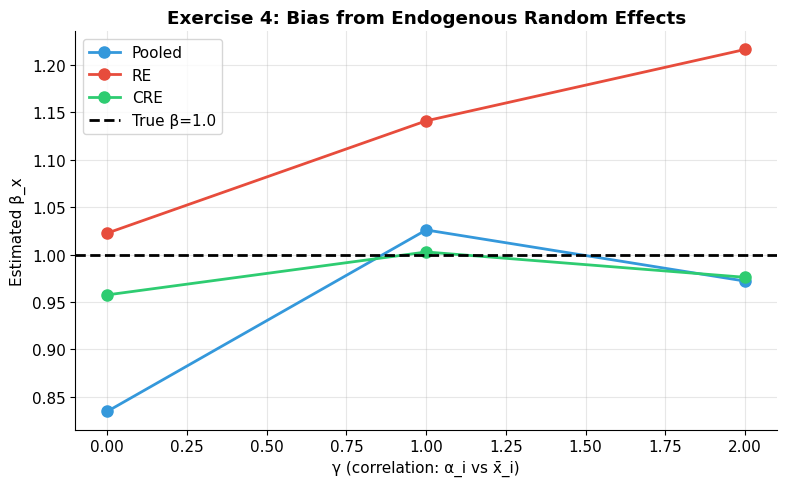


Conclusion: RE biased for γ>0; CRE remains ~unbiased.


In [22]:
# Exercise 4: Monte Carlo — endogenous effects (N=80, T=4 for speed)
N_mc, T_mc    = 80, 4
true_beta      = 1.0
sigma_u        = 0.5
rng_mc         = np.random.default_rng(123)
gamma_values   = [0.0, 1.0, 2.0]
mc_results     = {}

for gamma in gamma_values:
    x_mc    = rng_mc.normal(size=(N_mc, T_mc))
    x_bar   = x_mc.mean(axis=1)
    u_i     = rng_mc.normal(scale=sigma_u, size=N_mc)
    alpha_i = gamma * x_bar + u_i
    latent  = x_mc * true_beta + alpha_i[:, None] + rng_mc.normal(size=(N_mc, T_mc))
    y_mc    = (latent > 0).astype(int)

    ids_mc   = np.repeat(np.arange(N_mc), T_mc)
    years_mc = np.tile(np.arange(T_mc), N_mc)
    sim_mc   = pd.DataFrame({'id': ids_mc, 'year': years_mc,
                              'y': y_mc.flatten(), 'x': x_mc.flatten()})
    x_means_mc = sim_mc.groupby('id')['x'].mean().rename('x_mean')
    sim_mc_cre = sim_mc.merge(x_means_mc, on='id')

    print(f'γ={gamma}: Pooled, RE, CRE...', end=' ', flush=True)
    results_g = {}
    for model_name, formula, df_ in [
        ('Pooled', 'y ~ x', sim_mc),
        ('RE',     'y ~ x', sim_mc),
        ('CRE',    'y ~ x + x_mean', sim_mc_cre),
    ]:
        try:
            Cls = PooledProbit if model_name == 'Pooled' else RandomEffectsProbit
            kw  = {} if model_name == 'Pooled' else {'quadrature_points': 8}
            r   = Cls(formula, df_, 'id', 'year', **kw).fit()
            results_g[model_name] = r.params['x']
        except Exception:
            results_g[model_name] = np.nan
    mc_results[gamma] = results_g
    print({k: f'{v:.3f}' for k, v in results_g.items()})

mc_df = pd.DataFrame(mc_results).T
mc_df.index.name = 'γ'
print(f'\nTrue β = {true_beta}')
print('\nBias (Estimate − True β):')
print((mc_df - true_beta).round(4))

fig, ax = plt.subplots(figsize=(8, 5))
colors_mc = {'Pooled': '#3498db', 'RE': '#e74c3c', 'CRE': '#2ecc71'}
for model in ['Pooled', 'RE', 'CRE']:
    vals = [mc_results[g][model] for g in gamma_values]
    ax.plot(gamma_values, vals, 'o-', color=colors_mc[model], lw=2, markersize=8, label=model)
ax.axhline(y=true_beta, color='black', lw=2, linestyle='--', label=f'True β={true_beta}')
ax.set_xlabel('γ (correlation: α_i vs x̄_i)')
ax.set_ylabel('Estimated β_x')
ax.set_title('Exercise 4: Bias from Endogenous Random Effects', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/ex4_bias.png', dpi=80, bbox_inches='tight')
plt.show()
print('\nConclusion: RE biased for γ>0; CRE remains ~unbiased.')

---
## Summary

| Concept | Key takeaway |
|---|---|
| **RE Probit** | Integrates $\alpha_i \sim N(0,\sigma^2_\alpha)$ via Gauss-Hermite quadrature |
| **ICC ρ** | $\rho = \sigma^2_\alpha/(\sigma^2_\alpha+1)$; use LR test to check if significant |
| **Quadrature** | Q=12 sufficient for most applications |
| **CRE** | Add $\bar{\mathbf{x}}_i$ to RE model; Mundlak test for exogeneity |
| **Decision** | Pooled → LR test → RE → Mundlak → CRE/FE |
| **APE** | Scale coefficients by $E[\phi(\cdot)]$, integrate over $\alpha_i$ |
| **Caveat** | Normality of $\alpha_i$ assumed; robust to mild misspecification |

**Next**: `04_marginal_effects.ipynb` — Computing APE for all nonlinear panel models.